# NiftyRegPy Tutorial

This is a simple tutorial on how to use the niftyregpy package

## Installation

In [1]:
%%bash

[ -d /content/niftyreg ] && rm -r /content/niftyreg
git clone https://github.com/KCL-BMEIS/niftyreg/ /content/niftyreg
[ -d "niftyreg" ] && echo "niftyreg was downloaded successfully."

mkdir -p /content/niftyreg/build
cd /content/niftyreg/build
cmake .. &> /dev/null
make &> /dev/null
make install &> /dev/null


niftyreg was downloaded successfully.


Cloning into '/content/niftyreg'...


In [2]:
# Install niftyregpy and scikit-image (for transforms)
%pip install --quiet --ignore-installed git+https://github.com/fyrdahl/niftyregpy scikit-image

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Examples

In [3]:
import niftyregpy as nr
import numpy as np
import matplotlib.pyplot as plt

from skimage import transform


### Simple rigid registration
We create a test image with the built-in "create_test_image" function. Then we shift the test image slightly to create the "floating" image.

We then perform a single rigid registration step to try to register the shifted image to the original.

[[ 1.   -0.    0.   15.47]
 [ 0.    1.    0.   -0.42]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]



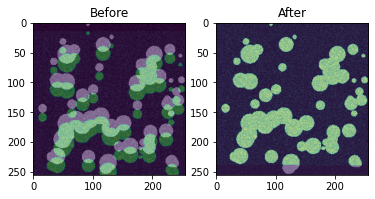

In [4]:
# Create a random test image containing blobs
img = nr.utils.create_test_image(blobs=64, max_rad=16)

# Add noise for robustness
img = np.abs(img + np.random.normal(0, 0.1, img.shape))

# Shift the image
img_shifted = np.zeros_like(img)
img_shifted[15:, :] = img[:-15, :]

# Perform one rigid registration
ref, flo = img, img_shifted
res = nr.reg.aladin(ref, flo, rigOnly=True)

# Print final affine transform matrix
print(f"{np.array_str(res[1], precision=2, suppress_small=True)}\n")

# Plot results
plt.figure()

plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.imshow(img_shifted, 'viridis', alpha=0.5)
plt.title('Before')

plt.subplot(1,2,2)
plt.imshow(img, 'gray')
plt.imshow(res[0], 'viridis', alpha=0.5)
plt.title('After')

plt.show()


### Serial rigid and affine registrations

Same as the previous example, except that we both shift and shear the image.

We then perform 5 registration steps, where the first step is constrained to be rigid and the subsequent steps are affine.

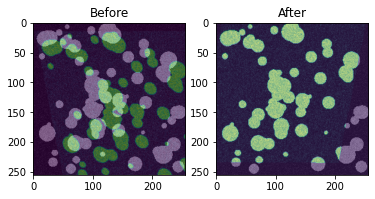

In [5]:
# Create a random test image containing blobs
img = nr.utils.create_test_image(blobs=64, max_rad=16)

# Add noise for robustness
img = np.abs(img + np.random.normal(0, 0.1, img.shape))

# Shift the image
img_shifted = np.zeros_like(img)
img_shifted[15:, :] = img[:-15, :]

# Shear the image using skimage
tform_shear = transform.AffineTransform(shear=np.pi/16)
img_sheared = transform.warp(img_shifted, tform_shear)

# Perform serial rigid and affine registrations
ref, flo = img, img_sheared
for iter in range(5):
  res = nr.reg.aladin(ref, flo, rigOnly=(iter==0), verbose=False)
  flo = res[0]

plt.figure()

plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.imshow(img_sheared, 'viridis', alpha=0.5)
plt.title('Before')

plt.subplot(1,2,2)
plt.imshow(ref, 'gray')
plt.imshow(res[0], 'viridis', alpha=0.5)
plt.title('After')

plt.show()


### Serial affine and non-rigid registration

Same as the previous example, except that we shift, shear and swirl the image.

We then perform 5 affine registrations steps, followed by 10 non-rigid registrations steps.

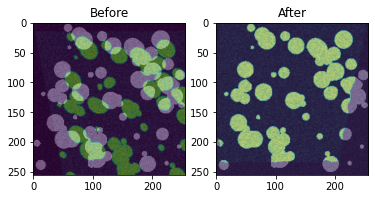

In [6]:
# Create a random test image containing blobs
img = nr.utils.create_test_image(blobs=64, max_rad=16)

# Add noise for robustness
img = np.abs(img + np.random.normal(0, 0.1, img.shape))

# Shift the image
img_shifted = np.zeros_like(img)
img_shifted[15:, :] = img[:-15, :]

# Shear the image using skimage
tform_shear = transform.AffineTransform(shear=np.pi/16)
img_sheared = transform.warp(img_shifted, tform_shear)

# Swirl the image using skimage
c = map(lambda x: x//2, img_sheared.shape)
img_swirled = transform.swirl(img_sheared, center=c, strength=1, radius=128)

# Perform serial rigid and affine registrations
ref, flo = img, img_swirled
for iter in range(5):
  res = nr.reg.aladin(ref, flo, rigOnly=(iter==0), verbose=False)
  flo = res[0]

# Perform serial non-rigid registrations
for iter in range(10):
  res = nr.reg.f3d(ref, flo)
  flo = res[0]

plt.figure()

plt.subplot(1,2,1)
plt.imshow(img, 'gray')
plt.imshow(img_swirled, 'viridis', alpha=0.5)
plt.title('Before')

plt.subplot(1,2,2)
plt.imshow(ref, 'gray')
plt.imshow(res[0], 'viridis', alpha=0.5)
plt.title('After')

plt.show()
